### RNG and (width, height) distributions

In [6]:
import numpy as np
from numpy.random._generator import Generator
import functools
from SquareDivision.src.distributions import x_plus_y_func
from SquareDivision.config import config

rng:Generator = np.random.default_rng(config['seed'])
func = functools.partial(x_plus_y_func, 
                         min_00=0.025, max_00=0.03,
                         min_11=0.2, max_11=0.3,
                         rng=rng)

### Random rectangulation and inflating to clinch

In [7]:
from SquareDivision.src.generators import uniform_pts
from SquareDivision.src.dataflow import arg_rect_list, process

# rng:Generator = np.random.default_rng(config['seed'])
arr = arg_rect_list(10, uniform_pts, func, rng=rng)
arr, pushed_arr = process(arr)

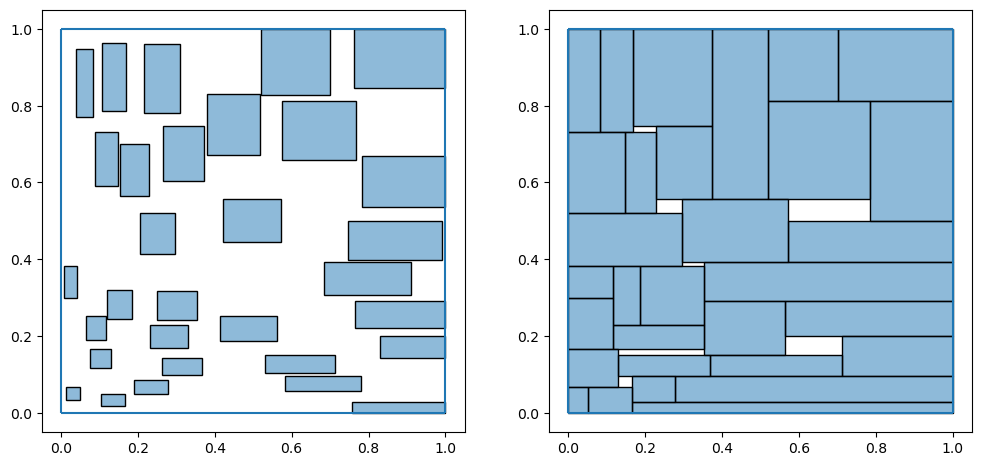

In [8]:
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles# , set_settings#, draw_suspended_walls
from SquareDivision.src.regions import opposing_walls_in_half_plane_in_dir

# suspect, direction = 5, 'u'
# which_list, sus_walls = opposing_walls_in_half_plane_in_dir(suspect, arr, direction)
# ax = draw_suspended_walls(ax, direction, sus_walls)

import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0] = draw_rectangles(axes[0], arr)
axes[1] = draw_rectangles(axes[1], pushed_arr)
plt.show()

## Projection onto retrangulation without holes

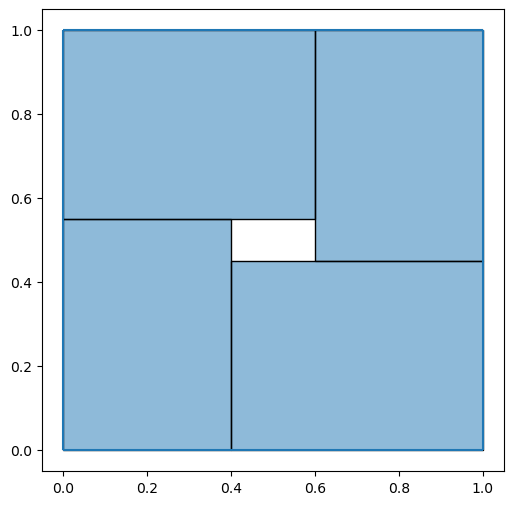

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles


width, height = np.array([0.2, 0.1]) / 2
rect_area = (0.5 - width)*(0.5 + height)
arr_with_hole = np.array([
    [          0,            0, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [          0, 0.5 + height, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
    [0.5 + width, 0.5 - height, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [0.5 - width,            0, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
])
#additional name for future
clinched_rectangles = arr_with_hole
fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, arr_with_hole)
plt.show()

east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])

In [39]:
arr_with_hole

array([[0.  , 0.  , 0.4 , 0.55, 0.22],
       [0.  , 0.55, 0.6 , 0.45, 0.27],
       [0.6 , 0.45, 0.4 , 0.55, 0.22],
       [0.4 , 0.  , 0.6 , 0.45, 0.27]])

### condition building on `[x, y, width, height, area]` such that:
sum of areas is 1, apropriate sums of height and width are 1, first build matrix `A`

In [2]:
east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])


In [ ]:

def build_A_and_rhs(arr, east_neighbours:np.ndarray, axis):
    """ Builds stack matricies for matrix equation (id - A) . X = rhs
            -----------------------------------------------------------------------------------------
            :   | id_lower   |     |    0       |       |           |           ...             |   :
            : ( | id_upper   |  -  |    0       | ).dot(|   Flatten(| x_i, y_i, w_i, h_i, ar_i  |)  :  
            :   | id_contact |     | A_contanct |       |           |           ...             |   :
            :       | 0 if rect on lower boundary  |                                                :
            :   ==  | 1 if rect on upper boundary  |                                                :
            :       | 0                            |                                                :
            -----------------------------------------------------------------------------------------
        The above repre4sents set of equalities:
            (id_lower)  :   for those on the left boundary
                x_i == 0
            (id_upper)  :   for those on the right boundary
                x_j + w_j == 1
            (id_contact):   for those rects which are upper neighbour of single contact e.g. index k
            (A_contanct):   for those rects which are lower neighbour of single contact e.g. index i
                x_k = x_i + w_i

        """
    # n - number of rectangles
    # m - number of contacts between rectangles 
    n, m = len(arr), np.sum(east_neighbours)
    id_lower   = np.zeros(shape=(5*n, 5*n))
    id_upper   = np.zeros(shape=(5*n, 5*n))
    id_contact = np.zeros(shape=(m, 5*n))
    zeros_of_A = np.zeros(shape=(5*n, 5*n))

    A_contanct = np.zeros(shape=(m, 5*n))
    rhs = np.zeros(shape=(2*(5*n) + m,))

    # first fill id_lower and id_upper for representation of 
    # x_i == 0 and x_j + w_j == 1 respectively
    for rect_num in range(n):
        if np.sum(east_neighbours.T[rect_num]) == 0:
            # rectangle is not an east neighbour of any other rectangle => it is on lower boundary
            id_lower[5*rect_num, 5*rect_num + axis] = 1
        if np.sum(east_neighbours[rect_num]) == 0:
            # rectangle has no east neighbours => it is on upper boundary
            id_upper[5*rect_num, 5*rect_num + axis], id_upper[5*rect_num, 5*rect_num + axis + 2] = 1, 1
            rhs[(5*n) + 5*rect_num + axis] = 1
    
    # now for contacts:
    for contact_num, (num_low_neighb, num_hig_neighb) in enumerate(zip(*np.where(east_neighbours > 0))):
        id_contact[contact_num, 5*num_low_neighb + axis] = 1
        A_contanct[contact_num, 5*num_hig_neighb + axis] = 1
        A_contanct[contact_num, 5*num_hig_neighb + axis + 2] = 1
    id_stack    = np.r_[id_lower,     id_upper, id_contact]
    A_stack     = np.r_[zeros_of_A, zeros_of_A, A_contanct]
    return id_stack, A_stack, rhs

#sanity check:
# id_X_stack, A_X_stack, X_rhs =  build_A_and_rhs(arr_with_hole, east_neighbours, 0)
# id_Y_stack, A_Y_stack, Y_rhs =  build_A_and_rhs(arr_with_hole, north_neighbours, 1)
# cont_A  = (id_X_stack-A_X_stack) + (id_Y_stack - A_Y_stack)
# cont_rhs= X_rhs + Y_rhs

In [3]:
id_X_stack, A_X_stack, X_rhs =  build_A_and_rhs(clinched_rectangles, east_neighbours, 0)
id_Y_stack, A_Y_stack, Y_rhs =  build_A_and_rhs(clinched_rectangles, north_neighbours, 1)
cont_A  = (id_X_stack-A_X_stack) + (id_Y_stack - A_Y_stack)
cont_rhs= X_rhs + Y_rhs

#### area constraint $\sum\limits_{i=1}^{n} \left| R_i \right| =1$


In [4]:
# area sum constraint
def build_A_for_area_sum(clinched_rectangles:np.ndarray):
    tile = np.array([0, 0, 0, 0, 1])
    vect = np.tile(tile, len(clinched_rectangles))
    return vect
A_for_area = build_A_for_area_sum(arr_with_hole)

# A_for_area.dot(arr_with_hole.flatten())
# A_for_area

#### Nonlinear Constraints w_i * h_i = ar_i

In [5]:
def fun_for_areas(arg: np.ndarray):
    array_arg = arg.reshape(-1, 5)
    widths, heights, areas = array_arg[:, 2], array_arg[:, 3], array_arg[:, 4]
    return (widths * heights) - areas

fun_for_areas(arr_with_hole.flatten())

array([0., 0., 0., 0.])

0.27

#### Linear and non-linear Constraints from `scipy.optimize`

In [6]:
# Arguments:

# linear conctact constraint aguments
id_X_stack, A_X_stack, X_rhs =  build_A_and_rhs(clinched_rectangles, east_neighbours, 0)
id_Y_stack, A_Y_stack, Y_rhs =  build_A_and_rhs(clinched_rectangles, north_neighbours, 1)
cont_A  = (id_X_stack-A_X_stack) + (id_Y_stack - A_Y_stack)
cont_rhs= X_rhs + Y_rhs

# linear area sum constraint
A_for_area_sum = build_A_for_area_sum(clinched_rectangles)

# nonlinear constraint width * height =  area
rect_count = len(clinched_rectangles)
non_lin_area_rhs = np.zeros(rect_count)

In [7]:
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

contact_constr = LinearConstraint( A=cont_A, lb=cont_rhs, ub=cont_rhs)
area____constr = LinearConstraint( A=A_for_area_sum, lb=1, ub=1)
nl_area_constr = NonlinearConstraint(fun=fun_for_areas, lb=non_lin_area_rhs, ub=non_lin_area_rhs)
cons = [contact_constr, area____constr, nl_area_constr]

#### distance function

In [8]:
from numpy import linalg as LA

def dist_fun(arg:np.ndarray, rectangles:np.ndarray=clinched_rectangles):
    arr = arg.reshape(-1,5)
    dist = LA.norm(arr-rectangles)
    return dist

dist_fun(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))

1.8214280112043957

#### `x0` the initial guess
In order to fullfil complicated contact conditions we : \
1) Find rectangle such that it has (x,y) = (0,0) this rectacnge and therefore that row\
will become the row: `[0, 0, 1, 1, 1]`
2) Rectangles on the most left (i.e. x=0) become: `[0, 1, 1, 0, 0]`
3) Rectangles on the bottom (i.e. y = 0) become: `[1, 0, 0, 1, 0]`
4) All other are squished to a point and become: `[1, 1, 0, 0, 0]`

In [9]:
def contact_universal_x0(clinched_rectangles:np.ndarray):
    x0=np.zeros(shape=clinched_rectangles.shape)
    for num, row in enumerate(clinched_rectangles):
        if np.isclose(row[0], 0) and np.isclose(row[1], 0):
            x0[num] = np.array([0, 0, 1, 1, 1])
            continue
        elif np.isclose(row[0], 0) and (not np.isclose(row[1], 0)):
            x0[num] = np.array([0, 1, 1, 0, 0])
            continue
        elif (not np.isclose(row[0], 0)) and np.isclose(row[1], 0):
            x0[num] = np.array([1, 0, 0, 1, 0])
            continue
        else:
            x0[num] = np.array([1, 1, 0, 0, 0])
    return x0
contact_universal_x0(clinched_rectangles)

array([[0., 0., 1., 1., 1.],
       [0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0.]])

In [ ]:
# # one rectangle (0,1),(0,1) the rest is squished to the point (1,1)
# def build_x0(clinched_rectangles:np.ndarray):
#     x0 = np.zeros(shape=clinched_rectangles.shape)
#     x0[0] = np.array([0,0,1,1,1])
#     return x0.flatten()
# # build_x0(arr_with_hole)
# def x0_cross_ab(a:float, b:float):
#     x0 = np.array([
#         [0, 0, a, b,a * b],
#         [a, 0, 1-a, b,(1-a)* b],
#         [0, b, a, 1-b,a*(1-b)],
#         [a, b, 1-a, 1-b,(1-a)*(1-b)],
#     ])
#     return x0.flatten()

#### bounds

In [10]:
def bounds_from_clinched(clinched_rectangles:np.ndarray):
    n, m = clinched_rectangles.shape
    lb = np.zeros(shape= n * 5)
    ub = np.ones(shape= n * 5)
    for num, row in enumerate(clinched_rectangles):
        idx = 5 * num
        if np.isclose(row[0], 0) and np.isclose(row[1], 0): 
            lb[idx], ub[idx], lb[idx+1], ub[idx+1] = 0, 0, 0, 0
            continue # keep (0,0) corner
        elif np.isclose(row[0], 0) and (not np.isclose(row[1], 0)):
            lb[idx], ub[idx] = 0, 0 
            continue # keep-left
        elif (not np.isclose(row[0], 0)) and np.isclose(row[1], 0):
            lb[idx+1], ub[idx+1] = 0, 0
            continue # keep-bottom
        else:
            continue
    return lb, ub
        

In [11]:
from scipy.optimize import Bounds
lb, ub = bounds_from_clinched(clinched_rectangles)
bounds = Bounds(lb=lb, ub=ub, keep_feasible=np.array([True]*20))

#### New functions fo constraints

In [2]:
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from SquareDivision.optimization.constraints import (
    low_boundary_constraint_args,
    high_boundary_constraint_args,
    contact_constraint_args,
    area_constraint_fun
)
from SquareDivision.optimization.objective_function import (
    dist_fun
)
from SquareDivision.optimization.initial_guess import (
    contact_universal_x0
)

In [5]:
clinched_rectangles = clinched_rectangles[:,:4]
low__X_A, low__X_rhs = low_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
low__Y_A, low__Y_rhs = low_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
high_X_A, high_X_rhs = high_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
high_Y_A, high_Y_rhs = high_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
low__X_constr = LinearConstraint( A=low__X_A, lb=low__X_rhs, ub=low__X_rhs)
low__Y_constr = LinearConstraint( A=low__Y_A, lb=low__Y_rhs, ub=low__Y_rhs)
high_X_constr = LinearConstraint( A=high_X_A, lb=high_X_rhs, ub=high_X_rhs)
high_Y_constr = LinearConstraint( A=high_Y_A, lb=high_Y_rhs, ub=high_Y_rhs)

cont_X_A, cont_X_rhs = contact_constraint_args(clinched_rectangles, east_neighbours, axis=0)
cont_Y_A, cont_Y_rhs = contact_constraint_args(clinched_rectangles, north_neighbours, axis=1)
horizontal_contacts = LinearConstraint( A=cont_X_A, lb=cont_X_rhs, ub=cont_X_rhs)
vertical___contacts = LinearConstraint( A=cont_Y_A, lb=cont_Y_rhs, ub=cont_Y_rhs)

area_constr = NonlinearConstraint(fun=area_constraint_fun, lb=0, ub=0)
constraints = [
    low__X_constr, low__Y_constr,
    high_X_constr, high_Y_constr,
    horizontal_contacts,
    vertical___contacts,
    area_constr]

x0 = contact_universal_x0(clinched_rectangles=clinched_rectangles).flatten()

In [7]:
from scipy.optimize import minimize
# x0 = build_x0(arr_with_hole)
# x0 = x0_cross_ab(0.2,0.3)
# x0 = contact_universal_x0(clinched_rectangles).flatten()
sol = minimize(dist_fun, x0, args=(clinched_rectangles), method='trust-constr', constraints=constraints)#, bounds=bounds)

d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


In [21]:
sol.x.reshape(-1,4)

array([[0., 0., 1., 1.],
       [0., 1., 1., 0.],
       [1., 1., 0., 0.],
       [1., 0., 0., 1.]])

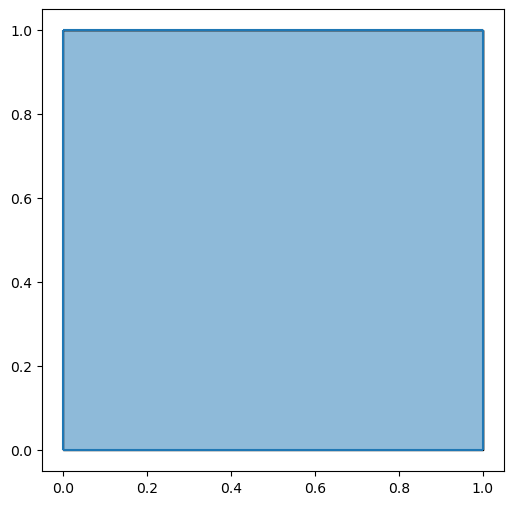

In [10]:
# FIX DRAWING FOR (-1,4) shape
rects_sol = sol.x.reshape(-1,4)
fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, np.c_[rects_sol,np.array([0,0,0,0])])
# ax = draw_rectangles(ax, clinched_rectangles)
plt.show()

In [14]:
dist_fun(rects_sol, clinched_rectangles)

1.753567791675018

In [18]:
guess = np.array(
    [[0.  , 0. , 0.4 , 0.5],
     [0.  , 0.5, 0.6 , 0.4],
     [0.6 , 0.5, 0.4 , 0.5],
     [0.4 , 0. , 0.6 , 0.5]])

In [19]:
dist_fun(guess,clinched_rectangles)

0.12247448713915894